### Задание
1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from datetime import timedelta

## 1. Подготовка данных

#### Считываем файлы и осуществляем предобработку данных

In [2]:
# Считываем файл с товарными позициями, входящими в заказ
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-zinurova/yana/Interim Project/olist_order_items_dataset .csv')
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [3]:
# Проверяем типы данных и пропущенные значения
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [4]:
# Формат даты определился неверно, поэтому меняем формат
items['shipping_limit_date'] = pd.to_datetime(items.shipping_limit_date)

In [5]:
# Снова проверяем тип данных
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [6]:
# Считываем файл с таблицей заказов
order = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-zinurova/yana/Interim Project/olist_orders_dataset .csv')
order.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
# Проверяем типы данных и пропущенные значения
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [8]:
# Формат даты определился неверно, поэтому меняем формат
order['order_purchase_timestamp'] = pd.to_datetime(order.order_purchase_timestamp)
order['order_approved_at'] = pd.to_datetime(order.order_approved_at)
order['order_delivered_carrier_date'] = pd.to_datetime(order.order_delivered_carrier_date)
order['order_delivered_customer_date'] = pd.to_datetime(order.order_delivered_customer_date)
order['order_estimated_delivery_date'] = pd.to_datetime(order.order_estimated_delivery_date)

In [9]:
# Снова проверяем тип данных
order.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [10]:
# Посчитаем пропущенные значения в столбцах
order.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Мы видим, что в датафрейме присутствуют нулевые значения. Посмотрим, почему такое может происходить. Возможно все дело в статусах заказов, давайте проверим эту гипотезу. Посмотрим, по каким статусам у нас присутствует наибольшее количество нулевых значений в интересующих нас полях "order_approved_at" и "order_delivered_customer_date".

Для начала посмотрим, сколько всего заказов у нас присутствует в каждом из статусов

In [11]:
order.groupby('order_status')['order_id'].count().sort_values(ascending = False)

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_id, dtype: int64

Сейчас посмотрим, по каким статусам заказов у нас присутствуют нулевые значения в поле "order_approved_at".

In [12]:
order.query('order_approved_at.isna()')\
     .groupby('order_status')['order_id'].count().sort_values(ascending = False)

order_status
canceled     141
delivered     14
created        5
Name: order_id, dtype: int64

Давайте разбираться. 1) 5 заказов были созданы, но не оплачены, здесь все понятно. 2) 141 заказ был отменен и не оплачен, или же отменен, потому что не оплачен, впрочем здесь все тоже понятно
3) 14 заказов были доставлены, но неоплачены. Вот это уже странно, давайте посмотрим на эти заказы.


In [13]:
order.query('order_approved_at.isna() and order_status =="delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


Действительно, данные 14 заказов были доставлены, по ним проставлена дата доставки, однако отсутствует дата оплаты. Учтем этот момент в дальнейшнем.

Теперь проверим, по каким статусам заказов у нас присутствуют нулевые значения в поле "order_delivered_customer_date"

In [14]:
order.query('order_delivered_customer_date.isna()')\
     .groupby('order_status')['order_id'].count().sort_values(ascending = False)

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_id, dtype: int64

Мы видим, что большая часть нулевых значений в поле с датой доставки приходится на заказы со статусами "отправлен", "отменен","недоступен", "выставлен счет","в процессе","создан"  и "подтвержден". Это в целом логичная ситуация, так как данные заказы не должны были/ еще не успели доставить. Однако здесь мы видим, что по статусу "доставлено" есть 8 заказов, по которым отсутствует дата доставки. Давайте посмотрим на эти заказы.

In [15]:
order.query('order_delivered_customer_date.isna() and order_status=="delivered"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


В половине случаев у доставленных заказов с отсутствующей датой доставки, дата передачи товара курьеру пришлась на 3 июля 2018. Можно предположить, что данные заказы были связаны с 1 курьером, который не отчитался о доставке товара, или же система в его случае дала сбой. В любом случае, будем считать данные товары доставленными и оплаченными, ориентируясь на их статус и дату оплаты.

Можно также заметить, что 6 отмененных были доставлены покупателю (625 заказов были отменены, при этом у 6 стоит дата доставки). Давайте посмотрим на такие заказы.

In [16]:
order.query('order_status=="canceled" and ~order_delivered_customer_date.isna()')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


Возможно, эти заказы были отменены уже после того, как они были доставлены получателю. Будем также считать их доставленными и оплаченными.

In [17]:
# Считываем файл с уникальными идентификаторами пользователей
cust = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-zinurova/yana/Interim Project/olist_customers_dataset.csv')
cust.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [18]:
# Проверяем типы данных и пропущенные значения
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Типы данных расставлены правильно, пропущенных значений нет

## 2. Задания

### 2.1. Сколько у нас пользователей, которые совершили покупку только один раз?

Покупкой будем считать товары, которые были оплачены, а именно заказы с проставленным полем 'order_approved_at'. Но мы помним, что есть 14 доставленных заказов, у которых отстутствует дата оплаты. Поэтому прибавим эти 14 заказов к общему количеству оплаченных заказов.

Количество пользователей будем определять по полю "customer_unique_id", а количество заказов по полю "customer_id" (альтернативно можно считать по order_id).

Для начала соединим таблицу с уникальным айдентификатором пользователей с таблицей заказов, при этом сразу же отфильтруем заказы, имеющие дату оплаты.

In [19]:
cust_order = cust.merge(order, on = 'customer_id', how = 'left')\
                 .query("~order_approved_at.isna()")

Далее посчитаем количество заказов, приходящихся на каждого пользователя, и, наконец, оставим только тех клиентов, кто завершил всего одну покупку


In [20]:
cust_order.groupby('customer_unique_id', as_index = False)['customer_id'].count()\
          .query('customer_id==1').customer_unique_id.count()

93049

Мы помним, что есть еще 14 доставленных заказов, у которых отсутствует дата оплаты. Добавим их к числу выше и получим 93063 пользователя, которые совершили всего 1 покупку

### 2.2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

В наших данных может быть 2 причины, по которым заказ не был доставлен И не будет доставлен. Это заказы со статусами "canceled" и "unavailable".

Создадим новый датафрейм, где не будем убирать неоплаченные заказы.

In [21]:
cust_order_full = cust.merge(order, on = 'customer_id', how = 'left')
cust_order_full.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


В качестве даты для анализа можно взять дату оплаты заказа 'order_approved_at' или дату создания заказа 'order_purchase_timestamp'.
С одной стороны, для бизнеса больше важна материальная составляющая, поэтому логичнее ориентироваться на дату оплаты. С другой стоороны, мы посмотрели, что примерно пятая часть (141/625*100%) заказов со статусом 'canceled' не были оплачены (возможно были отменены потому, что не были оплачены). Поэтому все же остановимся на дате создания заказа.

In [22]:
cust_order_full['order_purchase_month'] = cust_order_full.order_purchase_timestamp.dt.strftime('%Y-%m')
cust_order_full.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


Теперь посчитаем, сколько заказов пришлось на каждый месяц и на каждый статус, предварительно отфильтровав по статусу

In [23]:
cust_order_full.query('order_status in ("canceled","unavailable")')\
               .groupby(['order_status','order_purchase_month'], as_index = False).agg({'customer_id':'count'})\
               .groupby('order_status', as_index = False).agg({'customer_id':'mean'}).round()\
               .sort_values(by = 'customer_id', ascending = False)

,order_status,customer_id
1,unavailable,29.0
0,canceled,26.0


В среднем 29 заказов не доставляется по причине того, что товар недоступен, а 26 по причине того, что заказ был отменен.

### 2.3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

Товару у нас соответствует поле product_id, которое находится в таблице с товарными позициями, входящими в заказ. Для того чтобы решить задание, нам потребуется объединить таблицы с товарами и заказами. 

Покупкой также будем считать товары, которые были оплачены, а именно заказы с проставленным полем 'order_approved_at'.

Соединим датафреймы и сразу отфильтруем только те заказы, у которых проставлена дата оплаты

In [24]:
order_items = order.merge(items, how = 'outer', on = 'order_id')\
                   .query('~order_approved_at.isna()')
order_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


Создадим новое поле, где будет день недели даты заказа.

In [25]:
order_items['order_approved_week'] = order_items.order_approved_at.dt.strftime('%a')
order_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Mon
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thu
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wed
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Sat
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tue


Сгруппируем заказы по товару и дню недели, когда товар был оплачен, и посчитаем кол-во заказов, приходящийся на каждый из дней. После этого уберем дубликаты и оставим только популярные дни недели для заказа каждого из товаров.

In [26]:
order_items.groupby(['product_id','order_approved_week'], as_index = False).agg({'order_id':'count'})\
           .sort_values(by = 'order_id', ascending = False)\
           .groupby('product_id').head(1)\
           .reset_index(drop = True)\
           .drop(columns = 'order_id')

,product_id,order_approved_week
0,aca2eb7d00ea1a7b8ebd4e68314663af,Tue
1,53b36df67ebb7c41585e8d54d6772e08,Tue
2,422879e10f46682990de24d770e7f83d,Tue
3,99a4788cb24856965c36a24e339b6058,Tue
4,368c6c730842d78016ad823897a372db,Thu
...,...,...
32943,63dfa8b12200610ed7b5e41d3c888a25,Sat
32944,63e51e65ec59b56039c6427eed73dcf0,Tue
32945,63eb97106bfe47fe857edcf78f3e3e08,Sat
32946,63f52009dc3ddb733394e80183aed0f0,Sat


### 2.4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

Как и раньше, покупкой также будем считать товары, которые были оплачены, а именно заказы с проставленным полем 'order_approved_at'.

Для того учесть точное кол-во недель в месяце, нужно знать сколько дней было в месяце, а затем кол-во дней поделить на 7. Для этого создадим новую переменную

In [27]:
cust_order['week_length'] = cust_order.order_approved_at.dt.daysinmonth/7

Создадим переменную для обозначения месяца оплаты заказа

In [28]:
cust_order['order_approve_month'] = cust_order.order_approved_at.dt.strftime('%Y-%m')

Посмотрим, сколько покупок приходится на каждый месяц

In [29]:
cust_order.groupby(['order_approve_month','week_length'], as_index = False)\
          .agg({'order_id':'count'})

,order_approve_month,week_length,order_id
0,2016-09,4.285714,1
1,2016-10,4.428571,320
2,2016-12,4.428571,1
3,2017-01,4.428571,760
4,2017-02,4.000000,1765
5,2017-03,4.428571,2689
6,2017-04,4.285714,2374
7,2017-05,4.428571,3693
8,2017-06,4.285714,3252
9,2017-07,4.428571,3974


На сентябрь и декабрь 2016, а также на сентябрь 2018 приходится всего 1 покупка. Так как это может исказить наш результат, лучше исключить данные даты из анализа.

Посчитаем кол-во заказов на юзера в разбивке по месяцам.

In [30]:
cust_order2 = cust_order.query('order_approve_month not in ("2018-09","2016-09","2016-12")')\
                        .groupby(['customer_unique_id', 'order_approve_month','week_length'], as_index = False)\
                        .agg({'order_id':'count'})\
                        .sort_values('order_id', ascending = False)
cust_order2.head()

,customer_unique_id,order_approve_month,week_length,order_id
7316,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6
67663,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4.285714,4
14471,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4
50559,83e7958a94bd7f74a9414d8782f87628,2017-01,4.428571,4
69300,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.000000,4


Раделим ежемесячное количество заказов клиента на количество недель в месяце, чтобы получить среднее количество покупок в неделю по каждому пользователю.

In [31]:
cust_order2['purchase_per_week'] = cust_order2.order_id/cust_order2.week_length
cust_order2.head()

,customer_unique_id,order_approve_month,week_length,order_id,purchase_per_week
7316,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6,1.354839
67663,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4.285714,4,0.933333
14471,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4,0.933333
50559,83e7958a94bd7f74a9414d8782f87628,2017-01,4.428571,4,0.903226
69300,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.000000,4,1.000000


### 2.5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. (10 баллов)

Retention rate показывает отношение клиентов, которые вернулись за повторными покупками, к числу клиентов на начало расчетного периода. 

Для проведения когортного анализа нам понадобятся данные о клиентах и их покупках. У нас уже есть такой датафрейм - это cust_order.

В задании сказано, что нужно использовать данные с января по декабрь (судя по всему за 2018 год), то есть первая покупка клиентов должна быть осуществлена в этот период. Сгруппируем наши данные по "customer_unique_id" и найдем дату первой покупки, офтильтровав данные за нужный период. 

In [32]:
first_purchase = cust_order.groupby('customer_unique_id', as_index = False)\
                           .agg({'order_approve_month':'min'})\
                           .rename(columns = {'order_approve_month':'cohort'})\
                           .query('cohort>="2017-01" and cohort<="2017-12"')

In [33]:
first_purchase

,customer_unique_id,cohort
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11
8,0005e1862207bf6ccc02e4228effd9a0,2017-03
10,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07
...,...,...
95990,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12
95992,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06
95993,fffea47cd6d3cc0a88bd621562a9d061,2017-12
95994,ffff371b4d645b6ecea244b27531430a,2017-02


Соединим полученный датафрейм с даннами о всех покупках пользователей.

In [34]:
cohort = cust_order[['customer_unique_id','order_approve_month']]\
                   .merge(first_purchase, how = 'inner', on = 'customer_unique_id')
cohort.head()

,customer_unique_id,order_approve_month,cohort
0,861eff4711a542e4b93843c6dd7febb0,2017-05,2017-05
1,4c93744516667ad3b8f1fb645a3116a4,2017-09,2017-09
2,4c93744516667ad3b8f1fb645a3116a4,2017-10,2017-09
3,57b2a98a409812fe9618067b6b8ebe4f,2017-11,2017-11
4,2a7745e1ed516b289ed9b29c7d0539a5,2017-11,2017-11


Теперь посчитаем количество уникальных юзеров по когортам. Это нам понадобится для расчета Retention Rate (будет нашим знаменателем).

In [35]:
initial_cohort_users = cohort.groupby(['cohort'], as_index = False)\
                             .agg({'customer_unique_id':'nunique'})\
                             .rename(columns = {'customer_unique_id':'initial_users'})
initial_cohort_users.head()

,cohort,initial_users
0,2017-01,726
1,2017-02,1736
2,2017-03,2643
3,2017-04,2323
4,2017-05,3592


Теперь посчитаем, какое количество уникальных клиентов совершило покупки в разных месяцах

In [36]:
repurchase_cohort_users = cohort.groupby(['order_approve_month','cohort'], as_index = False)\
                                .agg({'customer_unique_id':'nunique'})
repurchase_cohort_users.head()

,order_approve_month,cohort,customer_unique_id
0,2017-01,2017-01,726
1,2017-02,2017-01,4
2,2017-02,2017-02,1736
3,2017-03,2017-01,2
4,2017-03,2017-02,4


Теперь соединим таблицы выше, чтобы посчитать Retention Rate

In [37]:
data = initial_cohort_users.merge(repurchase_cohort_users, on = 'cohort')
data.head()

,cohort,initial_users,order_approve_month,customer_unique_id
0,2017-01,726,2017-01,726
1,2017-01,726,2017-02,4
2,2017-01,726,2017-03,2
3,2017-01,726,2017-04,1
4,2017-01,726,2017-05,3


Создадим новую колонку, где разделим количество покупателей, совершивших повторную покупку в определенном месяце на общее количество покупателей в когорте.

In [38]:
data['retention_rate'] = (data.customer_unique_id/data.initial_users).round(6)
data.head()

,cohort,initial_users,order_approve_month,customer_unique_id,retention_rate
0,2017-01,726,2017-01,726,1.000000
1,2017-01,726,2017-02,4,0.005510
2,2017-01,726,2017-03,2,0.002755
3,2017-01,726,2017-04,1,0.001377
4,2017-01,726,2017-05,3,0.004132


Теперь посчитаем количество месяцев, которое прошло с момента первой покупки до момента повторной покупки. Для этого вычтем из даты повторной покупки первую дату покупки и запишем это в новую колонку. 

In [39]:
data['months_after_1purchase'] = (pd.to_datetime(data.order_approve_month) - pd.to_datetime(data.cohort)).astype('timedelta64[M]')
data.head()

,cohort,initial_users,order_approve_month,customer_unique_id,retention_rate,months_after_1purchase
0,2017-01,726,2017-01,726,1.000000,0.0
1,2017-01,726,2017-02,4,0.005510,1.0
2,2017-01,726,2017-03,2,0.002755,1.0
3,2017-01,726,2017-04,1,0.001377,2.0
4,2017-01,726,2017-05,3,0.004132,3.0


Теперь визуализируем наши данные так, чтобы по горизонтали было кол-во месяцев после 1ой покупки, а по вертикали название когорты.

In [40]:
data_pivot = data.query('months_after_1purchase!=0')\
                 .pivot_table(index='cohort', columns='months_after_1purchase', values='retention_rate', aggfunc='sum') 
data_pivot.head()

months_after_1purchase,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
cohort,,,,,,,,,,,,,,,,,,
2017-01,0.008265,0.001377,0.004132,0.001377,0.005510,0.001377,0.001377,NaN,0.002755,0.002755,0.008264,NaN,0.005509,0.001377,0.002755,0.004132,NaN,0.001377
2017-02,0.002304,0.001728,0.004032,0.001152,0.002304,0.001728,0.001152,0.002304,0.001152,0.002880,0.001728,0.001728,0.001152,0.000576,0.000576,0.002304,NaN,NaN
2017-03,0.004919,0.003405,0.003405,0.003405,0.001513,0.001513,0.003027,0.003027,0.001135,0.003784,0.003783,NaN,0.002648,NaN,0.002270,0.000757,0.001513,NaN
2017-04,NaN,0.003874,NaN,0.003013,0.002583,0.003444,0.002583,0.003444,0.001722,0.003013,0.000861,0.000430,0.000861,0.000861,NaN,0.002152,NaN,NaN
2017-05,0.005290,0.005011,0.003898,0.003062,0.003341,0.004176,0.001670,0.002506,0.005846,NaN,0.005290,NaN,0.002506,NaN,0.002506,NaN,NaN,NaN


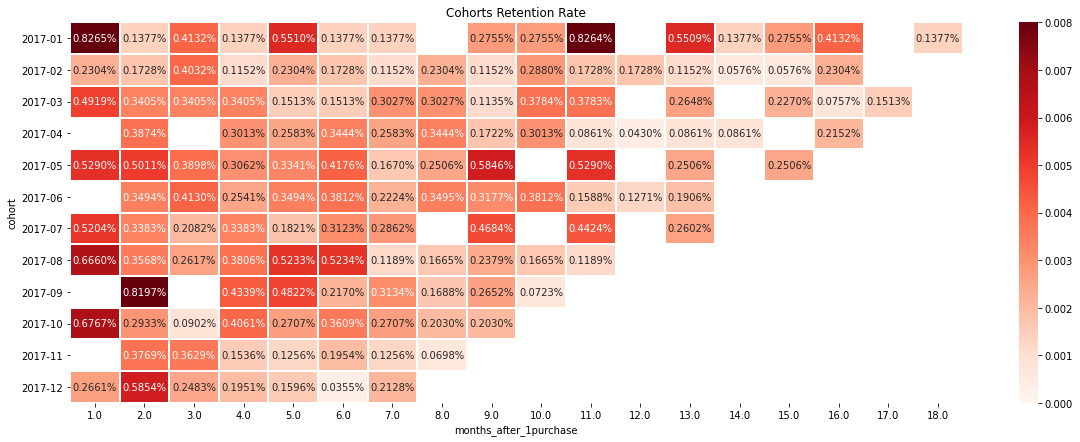

In [41]:
plt.figure(figsize=(20, 7))
plt.title('Cohorts Retention Rate')
sns.heatmap(data=data_pivot, annot=True, fmt='.4%', vmin = 0.0, vmax = 0.008, cmap='Reds', linecolor='white', linewidths=1)
plt.show()

Итак мы видим, что наибольший Retention Rate на 3ий месяц приходится на юзеров, которые совершили первую покупку в январе и июне 2017 года.

### 6. Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

Метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

Другими словами:

Recency — давность (как давно ваши пользователи что-то у вас покупали);
Frequency — частота (как часто они у вас покупают);
Monetary — деньги (общая сумма покупок).

Нам нужны данные по клиентам, частоте и сумме покупок их покупок. Для этого объединим 3 наши таблицы, оставив нужные колонки

In [42]:
df = cust_order.merge(items, on = 'order_id')\
               [['customer_unique_id','order_id','order_approved_at','price']]
df.head()

,customer_unique_id,order_id,order_approved_at,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,230.00


Посмотрим на временные рамки нашего датафрейма

In [43]:
print('Orders from {} to {}'.format(df['order_approved_at'].min(),
                                    df['order_approved_at'].max()))

Orders from 2016-09-15 12:16:38 to 2018-09-03 17:40:06


Для RFM анализа обычно используется период в 1 год, поэтому сразу же ограничим наш датафрейм одним годом, пусть это будет весь 2017 год

In [44]:
df = df.query('order_approved_at>="2017-01-01 00:00:00" and order_approved_at<="2017-12-31 23:59:59"')
df.head()

,customer_unique_id,order_id,order_approved_at,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,124.99
5,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,2017-09-14 18:25:11,259.90
7,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,2017-11-16 19:55:41,19.90
10,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,2017-11-27 18:01:20,25.30
12,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,2017-09-09 10:10:17,99.00


Посчитаем сумму покупок за каждый заказ за все время

In [45]:
df_data = df.groupby(['order_id', 'order_approved_at', 'customer_unique_id'], as_index = False).agg({'price':'sum'})
df_data.head()

,order_id,order_approved_at,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 09:45:35,871766c5855e863f6eccc05f988b23cb,58.9
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 11:05:13,eb28e67c4c0b83846050ddfb8a35d051,239.9
2,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 14:10:13,64b576fb70d441e8f1b2d7d446e483c5,199.9
3,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-17 03:55:27,85c835d128beae5b4ce8602c491bf385,21.9
4,00054e8431b9d7675808bcb819fb4a32,2017-12-10 12:10:31,635d9ac1680f03288e72ada3a1035803,19.9


Нам нужно посчитать, как давно наши юзеры совершали покупку, для этого нужно знать текущую дату. В качестве текущей даты возьмем крайний день покупки + 1 день

In [46]:
NOW = (df_data['order_approved_at'].max() + timedelta(days=1))
NOW

Timestamp('2018-01-01 23:32:40')

Так как мы решили анализировать данные за год, количество дней в нашем периоде равно 365.

In [47]:
period = 365

Создадим колонку, которая показывает количество дней с момента покупки до текущего времени

In [48]:
df_data['DaysSinceOrder'] = df_data['order_approved_at'].apply(lambda x: (NOW - x).days)

In [49]:
df_data.head()

,order_id,order_approved_at,customer_unique_id,price,DaysSinceOrder
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 09:45:35,871766c5855e863f6eccc05f988b23cb,58.9,110
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 11:05:13,eb28e67c4c0b83846050ddfb8a35d051,239.9,250
2,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 14:10:13,64b576fb70d441e8f1b2d7d446e483c5,199.9,331
3,00048cc3ae777c65dbb7d2a0634bc1ea,2017-05-17 03:55:27,85c835d128beae5b4ce8602c491bf385,21.9,229
4,00054e8431b9d7675808bcb819fb4a32,2017-12-10 12:10:31,635d9ac1680f03288e72ada3a1035803,19.9,22


Теперь мы можем приступить к подсчету score по нашим клиентам.

In [50]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # количество дней с момента последнего заказа (Recency)
    'order_approved_at': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # количество заказов за последний период (Frequency)
}
rfm = df_data.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_approved_at': 'Frequency'}, inplace=True)
rfm.head()

,customer_unique_id,Recency,Frequency
0,0000f46a3911fa3c0805444483337064,297,1
1,0000f6ccb0745a6a4b88665a16c9f078,81,1
2,0004aac84e0df4da2b147fca70cf8255,48,1
3,0005e1862207bf6ccc02e4228effd9a0,302,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1


Добавим к нашим данным денежную составляющую, а именно сумму всех покупок.

In [51]:
rfm['Monetary'] = rfm['customer_unique_id'].apply(lambda x: df_data[(df_data['customer_unique_id'] == x) & \
                                                           (df_data['order_approved_at'] >= NOW - timedelta(days=period))]\
                                                           ['price'].sum())
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000f46a3911fa3c0805444483337064,297,1,69.00
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90


Теперь визуализируем наши данные по каждой из колонок

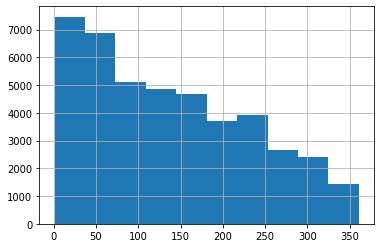

In [52]:
rfm.Recency.hist(bins = 10)

In [53]:
rfm.Recency.value_counts()

37     767
38     730
34     502
27     408
20     351
      ... 
356      6
357      4
361      3
358      3
360      2
Name: Recency, Length: 361, dtype: int64

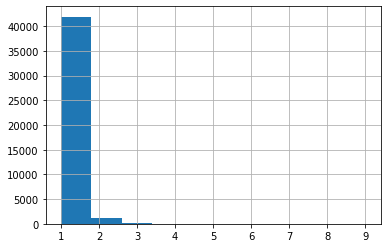

In [54]:
rfm.Frequency.hist(bins = 10)

In [55]:
rfm.Frequency.value_counts()

1    41929
2     1129
3       78
4       13
5        4
9        1
6        1
Name: Frequency, dtype: int64

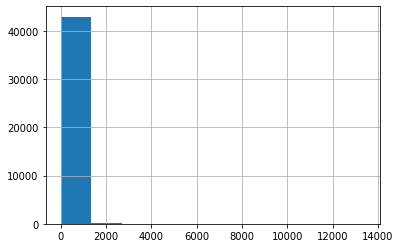

In [56]:
rfm.Monetary.hist(bins = 10)

In [57]:
rfm.describe()

,Recency,Frequency,Monetary
count,43155.000000,43155.000000,43155.000000
mean,137.733982,1.031352,142.414559
std,95.499491,0.196636,225.269571
min,1.000000,1.000000,2.290000
25%,48.000000,1.000000,47.990000
50%,123.000000,1.000000,89.000000
75%,214.000000,1.000000,155.675000
max,361.000000,9.000000,13440.000000


Итак, мы получили значения Recency, Frequency и Monetary. Теперь оценим каждого клиента по шкале от 1 до 3, исходя из описательной характеристики в данных

In [58]:
r = {'1': 48, '2': 214}
f = {'1': 2, '2': 4}
m = {'1': 48, '2': 156}

def r_score(x):
    if x<=r['1']:
        return 3
    elif x <=r['2']:
        return 2
    else:
        return 1
    
def f_score(x):
    if x<=f['1']:
        return 1
    elif x <=f['2']:
        return 2
    else:
        return 3
    
def m_score(x):
    if x<=m['1']:
        return 1
    elif x <=m['2']:
        return 2
    else:
        return 3

Присваиваем ранги от 1 до 3, где  будет предпочтительнее низкий ранг по Recency, и высокий ранг по Frequency и Monetary 

Получим R, F, M метрики для каждого клиента

In [59]:
rfm['R'] = rfm['Recency'].apply(r_score)
rfm['F'] = rfm['Frequency'].apply(f_score)
rfm['M'] = rfm['Monetary'].apply(m_score)
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,2,112
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,2,1,1,211
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,3,1,3,313
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,1,1,2,112
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211


Объединим R, F и M, чтобы получить RFM score

In [60]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM Score
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,2,112,112
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,2,1,1,211,211
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,3,1,3,313,313
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,1,1,2,112,112
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211,211


RFM анализ дал нам 27 сегментов, с этим сложно работать. Попробуем выделить 9 сегментов на основе метрик R и F.

In [61]:
segt_map = {
    r'11': 'одноразовые клиенты',
    r'12': 'неактивные клиенты, надо вернуть',
    r'13': 'любимые клиенты, нельзя потерять',
    r'21': 'клиенты в спячке. уйдут, если не реактивируем',
    r'22': 'клиенты нуждаются во внимании',
    r'23': 'лояльные клиенты',
    r'31': 'новые клиенты',
    r'32': 'потенциальные лоялисты',
    r'33': 'лучшие клиенты'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM Score,Segment
0,0000f46a3911fa3c0805444483337064,297,1,69.00,1,1,2,112,112,одноразовые клиенты
1,0000f6ccb0745a6a4b88665a16c9f078,81,1,25.99,2,1,1,211,211,"клиенты в спячке. уйдут, если не реактивируем"
2,0004aac84e0df4da2b147fca70cf8255,48,1,180.00,3,1,3,313,313,новые клиенты
3,0005e1862207bf6ccc02e4228effd9a0,302,1,135.00,1,1,2,112,112,одноразовые клиенты
4,0006fdc98a402fceb4eb0ee528f6a8d4,167,1,13.90,2,1,1,211,211,"клиенты в спячке. уйдут, если не реактивируем"


Визуализируем наши данные

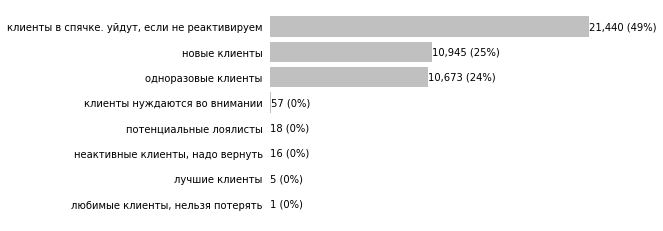

In [62]:
# Посчитаем количество клиентов в каждом сегменте
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Мы проанализировали клиентов, которые совершали покупки в 2017 году. RFM анализ показал, что большинство наших клиентов - это новички, одноразовики и клиенты, которые не так давно покупали по 1 товару. И действительно, наш анализ показал, что в среднем наши клиенты совершают по 1-2 покупке, при этом последняя покупка у них была более 4,5 месяцев назад.

Таким образом, мы разбили клиентов по категориям, и теперь мы можем работать над целевыми маркетинговыми кампаниями, чтобы удержать клиентов, находящихся в группе риска, улучшить продажи потенциальным клиентам и вознаградить лучших клиентов.